In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
customers = pd.read_csv("Customers.csv")
products = pd.read_csv("Products.csv")
transactions = pd.read_csv("Transactions.csv")

df = transactions.merge(products, on="ProductID", how="left")
df = df.merge(customers, on="CustomerID", how="left")

In [3]:
def preprocess_data(df):
    df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
    df['SignupDate'] = pd.to_datetime(df['SignupDate'])
    customer_features = df.groupby('CustomerID').agg({
        'TotalValue': ['sum', 'mean', 'count'],
        'Quantity': ['sum', 'mean'],
        'ProductID': 'nunique',
        'Category': lambda x: len(x.unique()),
        'Region': 'first',
        'SignupDate': 'first'
    }).reset_index()
    
    customer_features.columns = ['CustomerID', 'total_spend', 'avg_transaction_value', 
                               'transaction_count', 'total_quantity', 'avg_quantity',
                               'unique_products', 'unique_categories', 'region', 'signup_date']

    customer_features['account_age'] = (pd.Timestamp('2024-08-25') - 
                                      customer_features['signup_date']).dt.days
    customer_features['purchase_frequency'] = (customer_features['transaction_count'] / 
                                             customer_features['account_age'])
    
    customer_features['avg_spend_per_category'] = (customer_features['total_spend'] / 
                                                 customer_features['unique_categories'])
    
    region_dummies = pd.get_dummies(customer_features['region'], prefix='region')
    customer_features = pd.concat([customer_features, region_dummies], axis=1)
    customer_features = customer_features.drop(['region', 'signup_date'], axis=1)
    
    return customer_features

In [4]:
class LookalikeModel:
    def __init__(self, n_neighbors=3):
        self.scaler = StandardScaler()
        self.rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
        self.knn = NearestNeighbors(n_neighbors=n_neighbors+1, metric='cosine')
        self.n_neighbors = n_neighbors
        
    def create_customer_segments(self, X):
        X_copy = X.copy()
        X_copy['spend_segment'] = pd.qcut(X_copy['total_spend'], q=3, labels=['low', 'medium', 'high'])
        X_copy['frequency_segment'] = pd.qcut(X_copy['purchase_frequency'], q=3, labels=['low', 'medium', 'high'])
        X_copy['customer_segment'] = X_copy['spend_segment'].astype(str) + "_" + X_copy['frequency_segment'].astype(str)
        self.label_encoder = LabelEncoder()
        labels = self.label_encoder.fit_transform(X_copy['customer_segment'])
        
        return labels
    
    def fit(self, X):
        self.labels = self.create_customer_segments(X)
        self.X_scaled = self.scaler.fit_transform(X)
        X_train, X_test, y_train, y_test = train_test_split(
            self.X_scaled, self.labels, test_size=0.2, random_state=42
        )
        self.rf_classifier.fit(X_train, y_train)
        y_pred = self.rf_classifier.predict(X_test)
        self.metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, average='weighted'),
            'recall': recall_score(y_test, y_pred, average='weighted'),
            'f1': f1_score(y_test, y_pred, average='weighted')
        }
        self.knn.fit(self.X_scaled)
        return self
    
    def get_lookalikes(self, customer_idx):
        distances, indices = self.knn.kneighbors(self.X_scaled[customer_idx].reshape(1, -1))
        return indices[0][1:], 1 - distances[0][1:]  
    def get_feature_importance(self, feature_names):
        importance = pd.DataFrame({
            'feature': feature_names,
            'importance': self.rf_classifier.feature_importances_
        })
        return importance.sort_values('importance', ascending=False)

In [8]:
def plot_metrics(metrics):
    plt.figure(figsize=(10, 6))
    plt.bar(metrics.keys(), metrics.values())
    plt.title('Model Performance Metrics')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('model_metrics.png')
    plt.close()
    plt.show()

def format_recommendations(customer_id, recommendations):
    """Format recommendations as per required map structure"""
    rec_str = f"{customer_id}->["
    for i, rec in enumerate(recommendations):
        rec_str += f"({rec['similar_customer']},{rec['similarity_score']:.4f})"
        if i < len(recommendations) - 1:
            rec_str += ","
    rec_str += "]"
    return rec_str

In [6]:
def main():
    
    # Preprocess the data
    customer_features = preprocess_data(df)
    customer_ids = customer_features['CustomerID']
    features = customer_features.drop('CustomerID', axis=1)
    model = LookalikeModel(n_neighbors=3)
    model.fit(features)
    print("\nModel Evaluation Metrics:")
    for metric, value in model.metrics.items():
        print(f"{metric}: {value:.4f}")
    
    feature_importance = model.get_feature_importance(features.columns)
    plt.figure(figsize=(12, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
    plt.title('Top 10 Most Important Features')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.close()
    results = []
    for customer_id in [f'C{str(i).zfill(4)}' for i in range(1, 21)]:
        if customer_id in customer_ids.values:
            idx = customer_ids[customer_ids == customer_id].index[0]
            similar_indices, similarity_scores = model.get_lookalikes(idx)
            recommendations = [
                {'similar_customer': customer_ids.iloc[idx], 'similarity_score': score}
                for idx, score in zip(similar_indices, similarity_scores)
            ]
            map_string = format_recommendations(customer_id, recommendations)
            results.append(map_string)
    output_df = pd.DataFrame({'Map': results})
    output_df.to_csv('Lookalike.csv', index=False)
    from IPython.display import FileLink
    display(FileLink('Lookalike.csv'))
 
    plot_metrics(model.metrics)
    return output_df, model.metrics

In [7]:
if __name__ == "__main__":
    results_df, metrics = main()
    print("\nResults saved to Lookalike.csv")
    print("\nSample of results format:")
    print(results_df.head())


Model Evaluation Metrics:
accuracy: 0.9500
precision: 0.9542
recall: 0.9500
f1: 0.9486


C:\Users\purvi\Lookalike.csv


Results saved to Lookalike.csv

Sample of results format:
                                                 Map
0  C0001->[(C0174,0.9568),(C0152,0.9496),(C0107,0...
1  C0002->[(C0159,0.9080),(C0005,0.9065),(C0106,0...
2  C0003->[(C0129,0.8601),(C0190,0.7665),(C0091,0...
3  C0004->[(C0099,0.9335),(C0165,0.9236),(C0102,0...
4  C0005->[(C0159,0.9803),(C0007,0.9356),(C0002,0...


Model Evaluation Metrics:
accuracy: 0.9500
precision: 0.9542
recall: 0.9500
f1: 0.9486


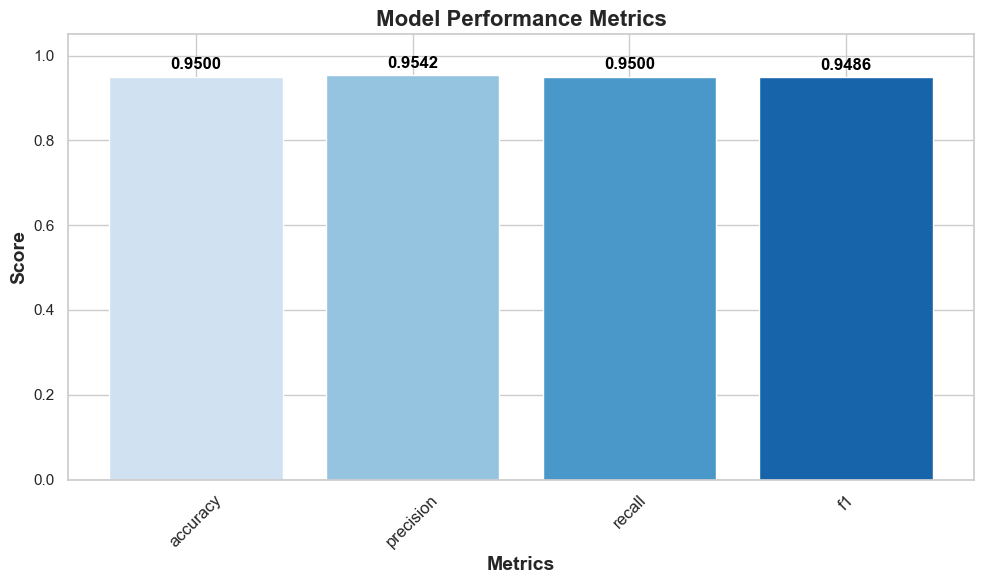

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_metrics(metrics):
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    bars = plt.bar(metrics.keys(), metrics.values(), color=sns.color_palette("Blues", n_colors=len(metrics)))
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2., height + 0.01, 
                 f'{height:.4f}',
                 ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')
    plt.title('Model Performance Metrics', fontsize=16, fontweight='bold')
    plt.ylabel('Score', fontsize=14, fontweight='bold')
    plt.xlabel('Metrics', fontsize=14, fontweight='bold')
    plt.ylim(0, 1.05)  

    plt.xticks(rotation=45, fontsize=12)
    plt.tight_layout()
    plt.savefig('model_metrics_beautiful.png')
    plt.show()
    plt.close()
model_evaluation_metrics = {
    'accuracy': 0.9500,
    'precision': 0.9542,
    'recall': 0.9500,
    'f1': 0.9486
}
print("Model Evaluation Metrics:")
for metric, value in model_evaluation_metrics.items():
    print(f"{metric}: {value:.4f}")
plot_metrics(model_evaluation_metrics)